# Tutorial 3: Stereo-seq

In this tutorial, we demonstrate how to apply GraphST to Stereo-seq data for spatial domains identification. We take mouse embryo 9.5 data as example and set the number of clusters as 22. Mouse embryo Stereo-seq data were downloaded from https://db.cngb.org/stomics/mosta/ and provided at https://drive.google.com/drive/folders/1QWHFMzhQ7WorVNLwx88xT-rbojf4nh9T.

Before running the model, please download input data by the link above. 

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt

from GraphST import GraphST

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

In [2]:
# dataset = 'Mouse_Embryo'

In [9]:
# Run device，by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
# os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'
os.environ['R_HOME'] = '/home/lytq/.conda/envs/SEDR/lib/R'

In [4]:
# the number of clusters
n_clusters = 7

## Reading data

In [7]:
# read data
file_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb/' 
adata = sc.read_h5ad(file_path + 'raw.h5ad')
adata.var_names_make_unique()

## Implementing GraphST for spatial clustering

In [10]:
# define model
model = GraphST.GraphST(adata, datatype='Stereo', device=device)

# run model
adata = model.train()

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 19109 × 27106
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'count'
Graph constructed!
Building sparse matrix ...
Begin to train ST data...
Debugging


100%|██████████| 600/600 [00:48<00:00, 12.42it/s]


Optimization finished for ST data!


## Spatial clustering

After model training, the representation for spots are generated and used as input of clustering tool for spatial clustering. Here we provid three available kinds of tools for spaital clustering, including mclust, leiden, and louvain. In our experiment, we find mclust performs better than leiden and louvain on spatial data in most cases. Therefore, we recommend using mclust.

In [11]:
# clustering
from GraphST.utils import clustering

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, method=tool) 
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, method=tool, start=0.1, end=2.0, increment=0.01)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [12]:
adata

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'
    layers: 'count'

## Visualization

In [25]:
output_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/RESULTS/Mouse_Olfactory_Bulb/GraphST/'
os.makedirs(output_path, exist_ok=True)

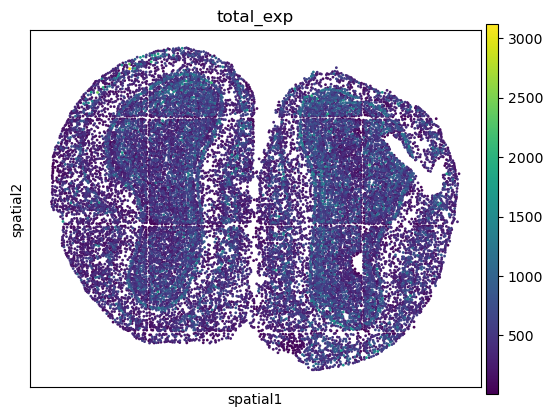

In [15]:
adata_org = sc.read_h5ad(file_path + 'raw.h5ad')

adata_org.obs['total_exp'] = adata_org.X.sum(axis=1)
fig, ax = plt.subplots()
sc.pl.spatial(adata_org, color='total_exp', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()

# plt.savefig(output_path + 'total_exp.png', dpi=300)

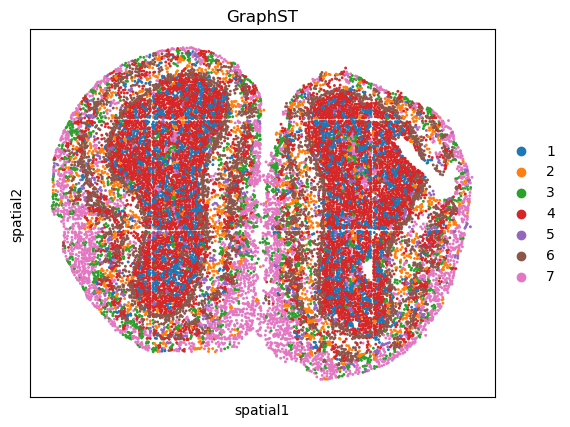

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color='domain', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()
ax.set_title('GraphST')

plt.savefig(output_path + 'clustering.pdf', dpi=300, bbox_inches='tight')

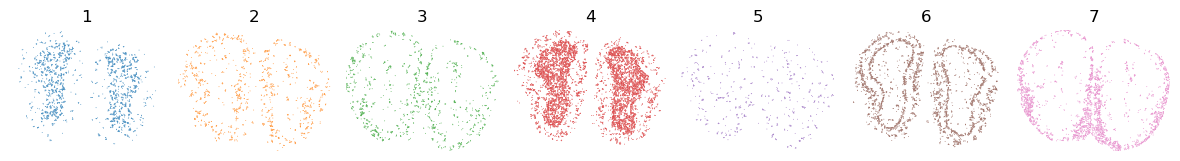

In [26]:
fig, axes = plt.subplots(1, n_clusters, figsize=(1.7 * n_clusters, 1.5 * 2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = adata[adata.obs['domain'] == i + 1]
    sc.pl.spatial(sub, spot_size=30, color='domain', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i + 1)

xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()

plt.savefig(output_path + 'each_cluster.pdf', dpi=300, bbox_inches='tight')


In [ ]:
# adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
# plt.rcParams["figure.figsize"] = (3, 4)
# plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
#            "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
#            "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
#           "#877F6C","#268785", '#82EF2D', '#B4EEB4']

# ax = sc.pl.embedding(adata, basis="spatial", 
#                     color="domain", 
#                     s=30, 
#                     show=False, 
#                     palette=plot_color,
#                     title='GraphST')
# ax.axis('off')
# ax.set_title('Mouse Embryo E9.5')

In [32]:
counts_file = os.path.join(file_path, 'RNA_counts.tsv')
coords_file = os.path.join(file_path, 'position.tsv')
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coords = pd.read_csv(coords_file, sep='\t')

In [34]:
counts.shape

(509, 19527)

In [35]:
coords.shape

(19527, 3)

In [36]:
coords

,x,y,label
0,12555.007833,6307.537859,1
1,12623.666667,6297.166667,2
2,12589.567164,6302.552239,3
3,12642.495050,6307.386139,4
4,13003.333333,6307.990991,5
...,...,...,...
19522,14656.130435,12156.869565,19888
19523,10717.785714,12189.571429,19889
19524,10872.913580,12190.123457,19890
19525,11628.769231,12191.846154,19891


In [40]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coords.index = coords['label'].map(lambda x: 'Spot_'+str(x))
coords = coords.loc[:, ['x','y']]

In [41]:
coords

,x,y
label,,
Spot_1,12555.007833,6307.537859
Spot_2,12623.666667,6297.166667
Spot_3,12589.567164,6302.552239
Spot_4,12642.495050,6307.386139
Spot_5,13003.333333,6307.990991
...,...,...
Spot_19888,14656.130435,12156.869565
Spot_19889,10717.785714,12189.571429
Spot_19890,10872.913580,12190.123457


In [43]:
coords = coords.loc[adata.obs_names, ['y', 'x']]
adata.obs['x'] = coords['x']
adata.obs['y'] = coords['y']
adata.obsm['spatial'] = coords.to_numpy()

In [44]:
adata

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'mclust', 'domain', 'x', 'y'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'domain_colors'
    obsm: 'spatial', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'
    layers: 'count'

In [46]:
used_barcode = pd.read_csv(os.path.join(file_path, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
used_barcode

0            Spot_1
1           Spot_10
2          Spot_100
3         Spot_1000
4        Spot_10000
            ...    
19104     Spot_9994
19105     Spot_9995
19106     Spot_9996
19107     Spot_9998
19108     Spot_9999
Name: 0, Length: 19109, dtype: object

In [47]:
adata = adata[used_barcode,]
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'mclust', 'domain', 'x', 'y'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'domain_colors'
    obsm: 'spatial', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'
    layers: 'count'

In [49]:
cell_metadata = adata.obs
cell_metadata

,mclust,domain,x,y
Spot_1,7,7,12555.007833,6307.537859
Spot_10,2,2,12806.715054,6311.983871
Spot_100,7,7,12752.469565,6425.617391
Spot_1000,6,6,12545.601942,6856.786408
Spot_10000,7,7,12993.429134,9153.204724
...,...,...,...,...
Spot_9994,2,2,14127.819588,9148.005155
Spot_9995,7,7,12933.872611,9147.484076
Spot_9996,7,7,13328.963303,9155.389908
Spot_9998,3,3,12637.854167,9150.281250


In [50]:
output_path

'/home/lytq/Spatial-Transcriptomics-Benchmark/RESULTS/Mouse_Olfactory_Bulb/GraphST/'

In [51]:
cell_metadata.to_csv(output_path + 'cell_metadata.csv')